# Causal and joint effects ($b$ and $g$)

$$
\newcommand{\Bin}{\operatorname{Bin}}
\newcommand{\Var}{\operatorname{Var}}
\newcommand{\Cov}{\operatorname{Cov}}
\newcommand{\Cor}{\operatorname{Cor}}
\newcommand{\E}{\operatorname{E}}
\newcommand{\diag}{\operatorname{diag}}
\newcommand{\tr}{\operatorname{tr}}
$$

In [1]:
%run library.ipynb

## Relating $b$ and $g$

First, consider what the "true" $g$ should be in terms of $b$ and the LD matrix.

$$
\begin{align}
Y & = X^T b + \epsilon \\
\hat{g} & = \left( X_T X^T_T \right)^{-1}X_TY \\
  & = \left( X_T X^T_T \right)^{-1} X_T \left( X^T b + \epsilon \right) \\
g & = \lim_{N\rightarrow\infty} \hat{g} \\
  & = \lim_{N\rightarrow\infty} \left( X_T X^T_T \right)^{-1} X_T \left( X^T b + \epsilon \right) \\
  & = \lim_{N\rightarrow\infty} \left( \frac{X_T X^T_T}{N} \right)^{-1} \frac{X_T X^T}{N} b \\
  & = S^{-1}_{TT} S_{TA} b \\
\gamma & = \Sigma^{-1}_{TT} \Sigma_{TA} \beta
\end{align}
$$

This is very similar to the results for $a$.

## Relating $\rho_b$ and $\rho_g$

When relating $\rho_g$ and $\rho_b$, you can use a similar derivation as with $\rho_a$:

$$
\begin{align}
\rho_g & = \rho_b \frac{ \tr \left[ S^{\left(1\right)}_{AT} \left(S^{\left(1\right)}_{TT}\right)^{-1} \left(S^{\left(2\right)}_{TT}\right)^{-1} S^{\left(2\right)}_{AT} \right] } { \sqrt{
\tr \left[ S^{\left(1\right)}_{AT} \left(S^{\left(1\right)}_{TT}\right)^{-1} \left(S^{\left(1\right)}_{TT}\right)^{-1} S^{\left(1\right)}_{AT} \right]
\tr \left[ S^{\left(2\right)}_{AT} \left(S^{\left(2\right)}_{TT}\right)^{-1} \left(S^{\left(2\right)}_{TT}\right)^{-1} S^{\left(2\right)}_{AT} \right]
} } \\
  & = \tau \left( S^{\left(1\right)}_{AT} \left(S^{\left(1\right)}_{TT}\right)^{-1}, S^{\left(2\right)}_{AT} \left(S^{\left(2\right)}_{TT}\right)^{-1} \right)
\end{align}
$$

Inverting $S^{\left(k\right)}_{TT}$ is going to be a real pain.

An alternate approach is to assume that pairs $g_{1i}$ and $g_{2i}$ are IID like $b_{1i}$ and $b_{2i}$. This is the assumption made by REML. Starting with $S^{\left(k\right)}_{TT}g_k = S^{\left(k\right)}_{TA}b_k$, we get:

$$
\begin{align}
\tau \left( S^{\left(1\right)}_{TT}, S^{\left(2\right)}_{TT} \right) \rho_g & =
\tau \left( S^{\left(1\right)}_{TA}, S^{\left(2\right)}_{TA} \right) \rho_b \\
\rho_g & = \frac{ \tau \left( S^{\left(1\right)}_{TA}, S^{\left(2\right)}_{TA} \right) } { \tau \left( S^{\left(1\right)}_{TT}, S^{\left(2\right)}_{TT} \right) } \rho_b
\end{align}
$$

### Testing

#### Simple test 1 - all SNPs nonzero have effect size

1. Sample $b$ from MVN ($\rho_b$ parameter)
1. Let $\Sigma^{\left(k\right)}$ be a block banded matrix
1. Sample $p_{ki} \sim Uniform \left( 0.05, 0.95 \right)$
1. Compute $S^{\left(k\right)} = \left(V^{\left(k\right)}\right)^{\frac{1}{2}} \Sigma^{\left(k\right)} \left(V^{\left(k\right)}\right)^{\frac{1}{2}}$
1. Compute $g_k = \left(S^{\left(k\right)}_{TT}\right)^{-1} S^{\left(k\right)}_{TA} b_k$
1. Sample $X_k \sim N \left(0, S^{\left(k\right)} \right)$
1. Compute $\hat{g}_k = \left( X_{kT} X_{kT}^T \right)^{-1} X_{kT} X_{k}^T b_k $
1. Calculate $\Cor\left(g_1, g_2\right)$, $\Cor\left(\hat{g}_1, \hat{g}_2\right)$, $\widehat{\Cor}\left(g_1, g_2\right)$ (bivariate HE regression) and $\frac{ \tau \left( S^{\left(1\right)}_{TA}, S^{\left(2\right)}_{TA} \right) } { \tau \left( S^{\left(1\right)}_{TT}, S^{\left(2\right)}_{TT} \right) }  \rho_b$.

In [2]:
def tau(Ss):
    return(
        np.sum(Ss[0]*Ss[1]) /
        np.sqrt(
            np.sum(Ss[0]*Ss[0]) *
            np.sum(Ss[1]*Ss[1])
        )
    )

In [3]:
def sim_b(rho_b, Ms, causal):
    bs = list()
    for M, flag in zip(Ms, causal):
        if flag:
            bs.append(
                multivariate_normal_sample(
                    np.zeros(2), 
                    equicorrelation_matrix(rho_b),
                    M
                ).T
            )
        else:
            bs.append(np.zeros((2,M)))
    bs = np.concatenate(bs, 1)
    return(bs)

In [4]:
def run_test(rho_b=0.8, M=100, R=(0.5, 0.2), K=(4, 2), causal=(True, True), N=None, binomial=False):
    # set up the number of untyped/typed SNPs    
    if type(M) is int:
        Ms = (M, M)
    else:
        Ms = M

    Mtot = Ms[0] + Ms[1]

    if N is None:
        N = 10*Mtot

    # sample b_k
    bs = sim_b(rho_b, Ms, causal)

    # create Sigma
    Sigmas = np.array([
        block_banded_matrix(r, k, Ms[0], Ms[1]) for r, k in zip(R, K)
    ])

    # sample ps and generate standard deviation
    ps = nr.uniform(0.05, 0.95, (2,2*M))
    Vs = 2*ps*(1-ps)
    sds = np.sqrt(Vs)

    # transform Sigmas to Ss
    Ss = np.array([
        Sigma * sd[:, None] * sd[None, :]
        for (Sigma, sd) in zip(Sigmas, sds)
    ])

    Rs = Ss / Vs[:,:,None]

    # calculate true gs
    gs = np.array([
        np.linalg.inv(S[Ms[0]:][:,Ms[0]:]).dot(S[Ms[0]:].dot(b))
        for (S, b) in zip(Ss, bs)
    ])

    # calculate true as
    As = (Rs * bs[:,None,:]).sum(axis=2)[:,Ms[0]:]

    # calculate rho_g/rho_b ratio
    if causal[0]:
        if causal[1]:
            numerator = tau(Ss[:,Ms[0]:])
        else:
            numerator = tau(Ss[:,Ms[0]:][:,:,:Ms[0]])
    else:
        if causal[1]:
            numerator = tau(Ss[:,Ms[0]:][:,:,Ms[0]:])
        else:
            numerator = 0
    ratio = numerator / tau(Ss[:,Ms[0]:][:,:,Ms[0]:])

    # sample genotypes
    Gs = np.array(
        [
            sim_geno(p, Sigma, N, binomial)
            for p, Sigma in zip(ps, Sigmas)
        ]
    )

    Xs = np.array([ G - G.mean(axis=0)[None,:] for G in Gs ])

    # generate phenotypes
    Ys = (Xs * bs[:,:,None]).sum(axis=1)
    Ys -= Ys.mean(axis=1)[:,None]

    # calculate ghat
    ghats = list()
    ahats = list()
    for X, Y in zip(Xs, Ys):
        Xt = X[Ms[0]:]
        XtY = Xt.dot(Y)
        ghats.append(
            np.linalg.inv(Xt.dot(Xt.T)).dot(XtY)
        )
        ahats.append(XtY / (Xt**2).sum(axis=1))

    # HE regression
    rho_hat = he_regression_bivar(Gs[0][Ms[0]:], Gs[1][Ms[0]:], Ys[0], Ys[1])[2]

    return({
        'cor(a1,a2)'        : np.corrcoef(As)[0,1],
        'cor(a1hat, a2hat)' : np.corrcoef(ahats)[0,1],
        'cor(g1,g2)'        : np.corrcoef(gs)[0,1],
        'cor(g1hat, g2hat)' : np.corrcoef(ghats)[0,1],
        'rho_g_HE'          : rho_hat,
        'ratio'             : ratio
    })

In [5]:
nr.seed(0)
test1_data = pd.DataFrame([run_test() for i in range(100)])

print(test1_data.mean())
print(test1_data.std())

cor(a1,a2)           0.707363
cor(a1hat, a2hat)    0.612025
cor(g1,g2)           0.763420
cor(g1hat, g2hat)    0.752847
ratio                0.956851
rho_g_HE             0.783671
dtype: float64
cor(a1,a2)           0.037832
cor(a1hat, a2hat)    0.052603
cor(g1,g2)           0.026207
cor(g1hat, g2hat)    0.029185
ratio                0.003430
rho_g_HE             0.052107
dtype: float64


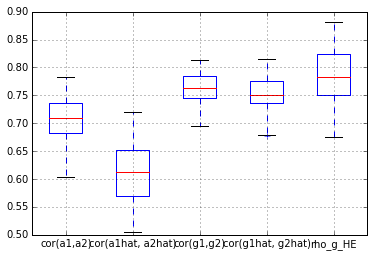

In [6]:
test1_data.iloc[:,[0,1,2,3,5]].boxplot(return_type='axes')
plt.show()

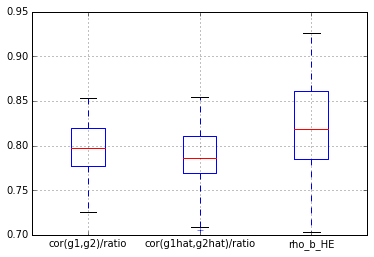

In [7]:
test1_corrected = pd.DataFrame(
    test1_data.values[:,[2,3,5]] / test1_data.values[:,4,None],
    columns=['cor(g1,g2)/ratio', 'cor(g1hat,g2hat)/ratio', 'rho_b_HE']
)

test1_corrected.boxplot(return_type='axes')
plt.show()

In [8]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,6)

#### Test 2 - binomial genotypes

In [9]:
nr.seed(0)
test2_data = pd.DataFrame([run_test(binomial=True) for i in range(100)])

print(test2_data.mean())
print(test2_data.std())

cor(a1,a2)           0.707363
cor(a1hat, a2hat)    0.600155
cor(g1,g2)           0.763420
cor(g1hat, g2hat)    0.743808
ratio                0.956851
rho_g_HE             0.774505
dtype: float64
cor(a1,a2)           0.037832
cor(a1hat, a2hat)    0.054800
cor(g1,g2)           0.026207
cor(g1hat, g2hat)    0.031300
ratio                0.003430
rho_g_HE             0.053609
dtype: float64


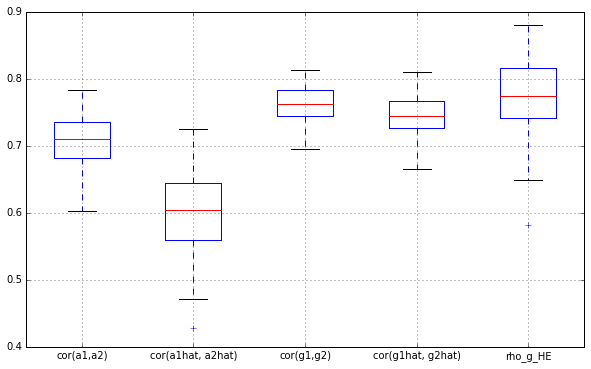

In [10]:
test2_data.iloc[:,[0,1,2,3,5]].boxplot(return_type='axes')
plt.show()

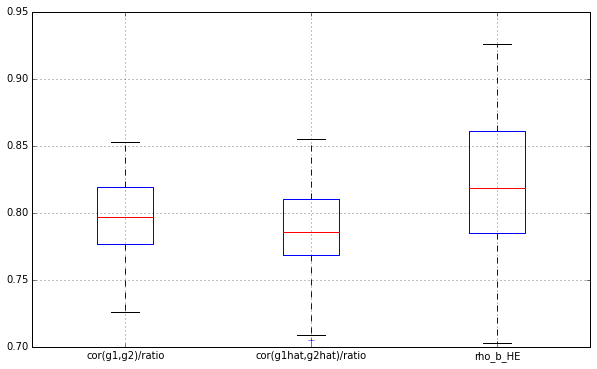

In [11]:
test2_corrected = pd.DataFrame(
    test2_data.values[:,[2,3,5]] / test2_data.values[:,4,None],
    columns=['cor(g1,g2)/ratio', 'cor(g1hat,g2hat)/ratio', 'rho_b_HE']
)

test1_corrected.boxplot(return_type='axes')
plt.show()

### Real LD

In [12]:
files = [
    '../phase2/ld/eas.eur.22.0.ld.bin',
    '../phase2/ld/eas.eur.22.1.ld.bin'
]

In [13]:
Sigmas = [ np.fromfile(f, 'double', -1, '') for f in files ]

Ms = [ int(np.sqrt(Sigma.shape[0])) for Sigma in Sigmas ]
M = 0

if (Ms[0] == Ms[1]):
    M = Ms[0]
    print("M={}".format(M))
else:
    print("Ms not equal")

Sigmas = np.array([ Sigma.reshape((M,M)) for Sigma in Sigmas ])

FileNotFoundError: [Errno 2] No such file or directory: '../phase2/ld/eas.eur.22.0.ld.bin'

In [ ]:
l = 0.1
lI = np.diag(np.full(M, l))

Sigma_primes = np.array([(Sigma + lI)/(1+l) for Sigma in Sigmas])

In [ ]:
def run_test_real_LD(rho_b=0.8, MT=1000, N=10000):
    typed = nr.choice(M, MT, replace=False)
    mask  = np.zeros(M, dtype='bool')
    mask[typed] = 1

    # sample ps and generate standard deviation
    ps = nr.uniform(0.05, 0.95, (2,M))
    Vs = 2*ps*(1-ps)
    sds = np.sqrt(Vs)
    
    Ss = np.array([
    Sigma * sd[:, None] * sd[None, :]
    for (Sigma, sd) in zip(Sigma_primes, sds)
    ])
    
    bs = multivariate_normal_sample(np.zeros(2), equicorrelation_matrix(0.8), M).T
    gs = np.array([np.linalg.inv(S[mask][:,mask]).dot(S[mask].dot(b)) for S, b in zip(Ss, bs)])

    Xs = np.array([nr.multivariate_normal(np.zeros(M), S, N) for S in Ss])
    Ys = np.array([X.dot(b) for (X, b) in zip(Xs, bs)])

    ghats = np.array([
        np.linalg.inv(X.T[mask].dot(X[:,mask])).dot(X.T[mask].dot(Y))
        for (X, Y) in zip(Xs, Ys)
    ])

    rho_hat = he_regression_bivar(Xs[0,:,mask], Xs[1,:,mask], Ys[0], Ys[1])[2]
    
    ratio = tau(Ss[:,mask]) / tau(Ss[:,mask][:,:,mask])

    return({
        'cor(g1,g2)'        : np.corrcoef(gs)[0,1],
        'cor(g1hat, g2hat)' : np.corrcoef(ghats)[0,1],
        'rho_g_HE'          : rho_hat,
        'rho_g'             : rho_b * ratio
    })

In [ ]:
run_test_real_LD(N=5000)

In [ ]:
test_real_LD_data = pd.DataFrame([run_test_real_LD() for i in range(5)])

print(test_real_LD_data.mean())
print(test_real_LD_data.std())

test_real_LD_data.boxplot(return_type='axes')
plt.show()

In [ ]:
q = pd.DataFrame([run_test_real_LD() for i in range(5)])

In [ ]:
pd.concat([test_real_LD_data, q]).boxplot()
plt.show()